In [1]:
import os
import gzip
import shutil
import requests

import numpy as np
import pandas as pd

import tensorflow as tf
from keras import Sequential, metrics
from keras.layers import Input, Dense, BatchNormalization, LSTM, Embedding, Bidirectional, Normalization, Conv1D, Dropout, MaxPool2D,MaxPooling1D, Flatten
from keras.models import Model

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve,roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA


2023-06-07 16:57:32.828856: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-07 16:57:32.874360: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-07 16:57:32.875910: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-07 16:57:34.069918: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [22]:
df = input_df

disease_df = df[df['DiseaseID'] == 'MESH:D010300']
print(disease_df[:5])

disease_df.to_csv('unzipped_data/MESH:D010300.csv')

# 


                                           ChemicalName ChemicalID      CasRN  \
189               10,11-dihydro-10-hydroxycarbamazepine    C039775        NaN   
769                               10-deacetylpaclitaxel    C095360        NaN   
1284                            10-hydroxynortriptyline    C013567  1156-99-6   
1907  10-methyl-3-(6-methylpyridin-3-yl)-9,10,11,12-...    C549914        NaN   
2734                                10-nitro-oleic acid    C521487        NaN   

            DiseaseName     DiseaseID DirectEvidence InferenceGeneSymbol  \
189   Parkinson Disease  MESH:D010300            NaN               ABCB1   
769   Parkinson Disease  MESH:D010300            NaN               ABCB1   
1284  Parkinson Disease  MESH:D010300            NaN              CYP2D6   
1907  Parkinson Disease  MESH:D010300            NaN                 TNF   
2734  Parkinson Disease  MESH:D010300            NaN               GSTA4   

      InferenceScore OmimIDs        PubMedIDs\n  
189   

In [2]:
VERBOSE=False
EPOCHS=25
TRAIN_SIZE=.75

METRICS = [
      metrics.TruePositives(name='tp'),
      metrics.FalsePositives(name='fp'),
      metrics.TrueNegatives(name='tn'),
      metrics.FalseNegatives(name='fn'), 
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc'),
      metrics.AUC(name='prc', curve='PR')
]

## get the data

In [5]:
import gzip
import shutil

def download_resource(resource: str) -> str:

    url_dl_pattern = 'http://ctdbase.org/reports/{resource}.csv.gz'
    url = url_dl_pattern.format(resource=resource)
    
    print('downloading: {0}'.format(resource))
    local_filename = 'zipped_data/' + url.split('/')[-1]
    unzipped_filename = 'unzipped_data/' + url.split('/')[-1].replace('.gz', '')
    
    if os.path.isfile(unzipped_filename):
        print('data already exists')
        return 

    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                f.write(chunk)

    with gzip.open(local_filename, 'rb') as f_in:
        with open(unzipped_filename, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    
    return local_filename


resources = [
#     'CTD_chem_gene_ixn_types',
#     'CTD_chem_pathways_enriched',
#     'CTD_genes_diseases',
#     'CTD_genes_pathways',
#     'CTD_diseases_pathways',
#     'CTD_pheno_term_ixns',
#     'CTD_exposure_studies',
#     'CTD_chemicals',
#     'CTD_genes',
    'CTD_chem_gene_ixns',
    'CTD_chemicals_diseases',
    'CTD_diseases'
]

for res in resources:
    download_resource(res)

def get_df(resource: str) -> pd.DataFrame:
    line_number = 27 ## all the files have the same header 
    the_file = 'unzipped_data/{resource}.csv'.format(resource=resource)
    with open(the_file, 'r') as reader:
        for i, row in enumerate(reader):
            if i == line_number:
                header = row.replace('# ', '').split(',')

    df = pd.read_csv(the_file, skiprows=29, names=header)
    return df

downloading: CTD_chem_gene_ixns
data already exists
downloading: CTD_chemicals_diseases
data already exists
downloading: CTD_diseases
data already exists


In [8]:
class DiseaseClassifier:
    def __init__(self, input_df, parent_disease, gene_count, show_plots, use_class_weights, oversample, model_type, classification='binary'):
        self.input_df = input_df
        self.parent_disease = parent_disease
        self.target_diseases = self.get_diseases()
        self.gene_count = gene_count
        self.show_plots = show_plots
        self.stop_early = True
        self.use_class_weights = use_class_weights
        self.oversample = oversample
        self.model_type = model_type
        self.classification = classification
        self.top_n_genes = self.get_genes()

        if self.use_class_weights and self.oversample:
            raise Exception('Need to either use classweights OR oversample')
    
    def get_diseases(self):
        
        disease_df = get_df('CTD_diseases')
        disease_df['ParentIDs'].str.split('|').explode()

        hierarchy_df = disease_df\
            .assign(ParentIDs=disease_df['ParentIDs'].str.split('|')).explode('ParentIDs')
        
        levels = 3
        
        all_diseases = [self.parent_disease]
        current_level = hierarchy_df.loc[hierarchy_df['ParentIDs'] == self.parent_disease]
        for level in range(levels):
            children = list(current_level['DiseaseID'].unique())
            all_diseases.extend(children)
            next_level = hierarchy_df.loc[hierarchy_df['ParentIDs'].isin(children)]
            current_level = next_level
        
        return all_diseases
    
    def get_genes(self):
        gene_df = pd.DataFrame(self.input_df.groupby(['InferenceGeneSymbol']).size()).reset_index()
        gene_df.columns = ['InferenceGeneSymbol','cnt']
        top_n_genes_df = gene_df.sort_values('cnt', ascending=False)[:self.gene_count]
        top_n_genes = top_n_genes_df['InferenceGeneSymbol'].unique()

        return top_n_genes
    
    def prep_training_data(self):
        
        gene_df = self.input_df.loc[self.input_df['DirectEvidence'].isnull()][['ChemicalName', 'DiseaseName', 'InferenceGeneSymbol', 'InferenceScore', 'DiseaseID']]

        gene_df = gene_df.loc[gene_df['InferenceGeneSymbol'].isin(self.top_n_genes)]

        evidence_df = self.input_df.loc[self.input_df['DirectEvidence'].notnull()][['ChemicalName', 'DiseaseName', 'DirectEvidence', 'DiseaseID']]
        merged_df = gene_df.merge(evidence_df, on=['ChemicalName', 'DiseaseName', 'DiseaseID'])

        dummy_df = pd.get_dummies(merged_df, prefix='', prefix_sep='',columns=['InferenceGeneSymbol'])
        gb_df = dummy_df.groupby(['DiseaseName', 'ChemicalName', 'DiseaseID']).agg({np.max}).reset_index()

        gb_df.columns = gb_df.columns.droplevel(1)

        gb_df['label'] = np.where(gb_df['DirectEvidence'] == 'marker/mechanism',
                                                   gb_df['InferenceScore'] * -1,
                                                   gb_df['InferenceScore'])
        
        return gb_df
    
    def plot_results(self, history, predicted_values, y_test, accuracy):

        ## to do, subclass categorical classifications.. override this method
        if self.classification == 'categorical':

            cm = confusion_matrix(y_test.argmax(axis=1), predicted_values.argmax(axis=1))

            labels = ['Not Relevant', 'Therapeutic', 'Negative']
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

            disp.plot(cmap=plt.cm.Blues) # xticks_rotation=45
            return 0

        auc_score = roc_auc_score(y_test, predicted_values) 
        
        if not self.show_plots:
            return auc_score
        
        # plot accuracy
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
        axes[0][0].plot(history.history['accuracy'],label='accuracy')
        axes[0][0].plot(history.history['val_accuracy'],label='val_accuracy')
        axes[0][0].text(2, history.history['accuracy'][0] + .005, 'accuracy: {:.4f}'.format(accuracy))

        axes[0][0].legend()

        # plot loss
        axes[0][1].plot(history.history['loss'],label='loss')
        axes[0][1].plot(history.history['val_loss'],label='val_loss')
        axes[0][1].legend()
        fig.tight_layout()

        fpr, tpr, thresholds = roc_curve (y_test , predicted_values)

        # plot_roc_curve
        axes[1][0].plot(fpr,tpr)
        axes[1][0].text(0.7, 0.9, 'auc: {:.4f}'.format(auc_score))
        axes[1][0].axis([-.05,1.1,0,1.05]) 

        # plot confusion matrix
        cm = confusion_matrix(y_test, np.where(predicted_values > 0.5, 1, 0))

        labels = ["Non Target", "Target"]
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

        disp.plot(cmap=plt.cm.Blues, ax=axes[1][1]) # xticks_rotation=45

        return auc_score
    
    def get_class_weights(self, labels):
        """
        Determine the weights to assign to each class based on the distribution of classes 
        """

        classes = labels.unique()
        total_classes = len(classes)

        total = len(labels)

        cl_weight = {}
        for cl in classes:
            count_of_this_class = len([x for x in labels if x == cl]) # optimize this.. 
            cl_weight[cl] = (1 / count_of_this_class) * (total / total_classes)

        return cl_weight
    
    def get_model(self, input_shape, output_shape):
        model = Sequential()
        
        
        if self.model_type == 'CNN':
            model.add(Conv1D(64, 2, activation="relu", input_shape=(input_shape,1)))
            model.add(Dense(16, activation="relu"))
            model.add(MaxPooling1D())
            model.add(Flatten())
            model.add(Dense(output_shape, activation = 'sigmoid'))
        else:
            model.add(Dense(60, input_dim=input_shape, activation='relu'))
            model.add(Dense(6, input_dim=input_shape, activation='relu'))
            model.add(Dense(output_shape, activation='sigmoid'))

        model.compile(loss=self.classification + '_crossentropy', optimizer='adam', metrics=METRICS)
        return model
    
    def over_sample(self, X_train, y_train):
        if self.classification == 'categorical':
            raise Exception('over sampling not supported with categorical classifications')
        bool_train_labels = y_train != 0

        pos_features = X_train[bool_train_labels]
        neg_features = X_train[~bool_train_labels]

        pos_labels = y_train[bool_train_labels]
        neg_labels = y_train[~bool_train_labels]

        ids = np.arange(len(pos_features))
        choices = np.random.choice(ids, len(neg_features))

        res_pos_features = pos_features.iloc[choices, :]
        res_pos_labels = pos_labels.values[choices] # pos_labels.array(choices)

        res_pos_features.shape

        resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
        resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

        order = np.arange(len(resampled_labels))
        np.random.shuffle(order)
        resampled_features = resampled_features[order]
        resampled_labels = resampled_labels[order]

        return resampled_features, resampled_labels
        
    def train_model(self, train_df):

        gene_columns = train_df.columns.intersection(self.top_n_genes)
        shuffled_df = train_df.sample(frac=1)
        features, labels = shuffled_df[gene_columns], shuffled_df['binary_label']
        
        if self.classification == 'categorical':
            enc = OneHotEncoder()
            labels = enc.fit_transform(shuffled_df['categorical_label'][:, np.newaxis]).toarray()
        
        output_layer_num = labels.shape[1] if self.classification == 'categorical' else 1
        model = self.get_model(features.shape[1], output_layer_num)
        
        X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=0, train_size=TRAIN_SIZE)
        
        if self.oversample:
            X_train, y_train = self.over_sample(X_train, y_train)
        
        callbacks = []
        if self.stop_early:
            callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2))
        
        model_fit_kw = {
            'x': X_train,
            'y': y_train,
            'epochs':25,
            'validation_split':0.2,
            'callbacks':callbacks,
            'verbose':VERBOSE
        }
        if self.use_class_weights:
            label_column = self.classification + '_label'
            model_fit_kw['class_weight'] = self.get_class_weights(train_df[label_column])
        
        ## fit the model
        history = model.fit(**model_fit_kw)
        
        ## make predictions on the test set
        predicted_values = model.predict(X_test)

        model_metrics = model.evaluate(X_test, y_test, verbose=VERBOSE)
        model_keys = ['loss'] + [m.name for m in METRICS]
        metrics_info = dict(zip(model_keys, model_metrics))

        auc = self.plot_results(history, predicted_values, y_test, metrics_info.get('accuracy'))

        
        return history,model, auc, metrics_info

    def apply_category(self, row):
        if row.binary_label == 0:
            return 0 # 'Not Releveant'
        if row.DirectEvidence == 'marker/mechanism':
            return 1 # 'Negative'
        else:
            return 2 # 'Therapeutic'
    
    def set_label(self, train_df):

        target_diseases = self.get_diseases()
        train_df['binary_label'] = np.where(train_df['DiseaseID'].isin(target_diseases),1, 0)

        if self.classification == 'categorical':
            train_df['categorical_label'] = train_df.apply(lambda row: self.apply_category(row), axis=1)

        return train_df
        
   
    def main(self):
        train_df = self.prep_training_data()
        train_df = self.set_label(train_df)
        history, model, auc, model_metrics =  self.train_model(train_df)

        model_metrics['parent_disease'] = self.parent_disease
        model_metrics['gene_count'] = self.gene_count
        model_metrics['show_plots'] = self.show_plots
        model_metrics['use_class_weights'] = self.use_class_weights
        model_metrics['oversample'] = self.oversample
        model_metrics['model_type'] = self.model_type
               
        return model_metrics, model
        


In [9]:
input_df = get_df('CTD_chemicals_diseases')

/tmp/ipykernel_129/1037808455.py:56: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(the_file, skiprows=29, names=header)


## DNN with class weights

418/418 [==============================] - 1s 2ms/step


,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc,parent_disease,gene_count,show_plots,use_class_weights,oversample,model_type
0,0.145596,101.0,815.0,12431.0,20.0,0.937533,0.110262,0.834711,0.95917,0.639222,MESH:D019636,1000,True,True,False,DNN


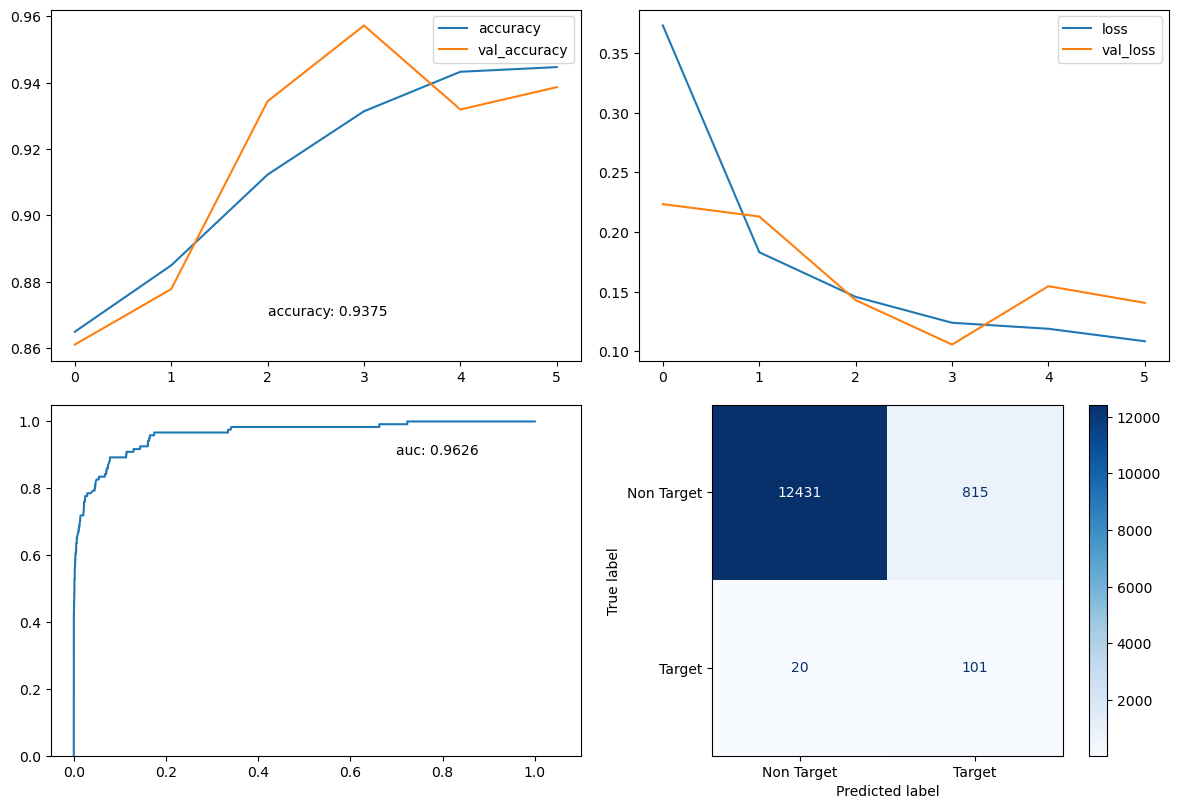

In [10]:
kw = {
    'input_df': input_df,
    'parent_disease': 'MESH:D019636', # neurodegenerative diseases
    'gene_count': 1000,
    'model_type':'DNN',
    'show_plots': True,
    'use_class_weights': True,
    'oversample': False
}
dc = DiseaseClassifier(**kw)
dc_mm, _ = dc.main()
display(pd.DataFrame([dc_mm]))

## DNN with Oversampling

2023-06-07 17:06:57.291333: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 63516000 exceeds 10% of free system memory.


418/418 [==============================] - 1s 3ms/step


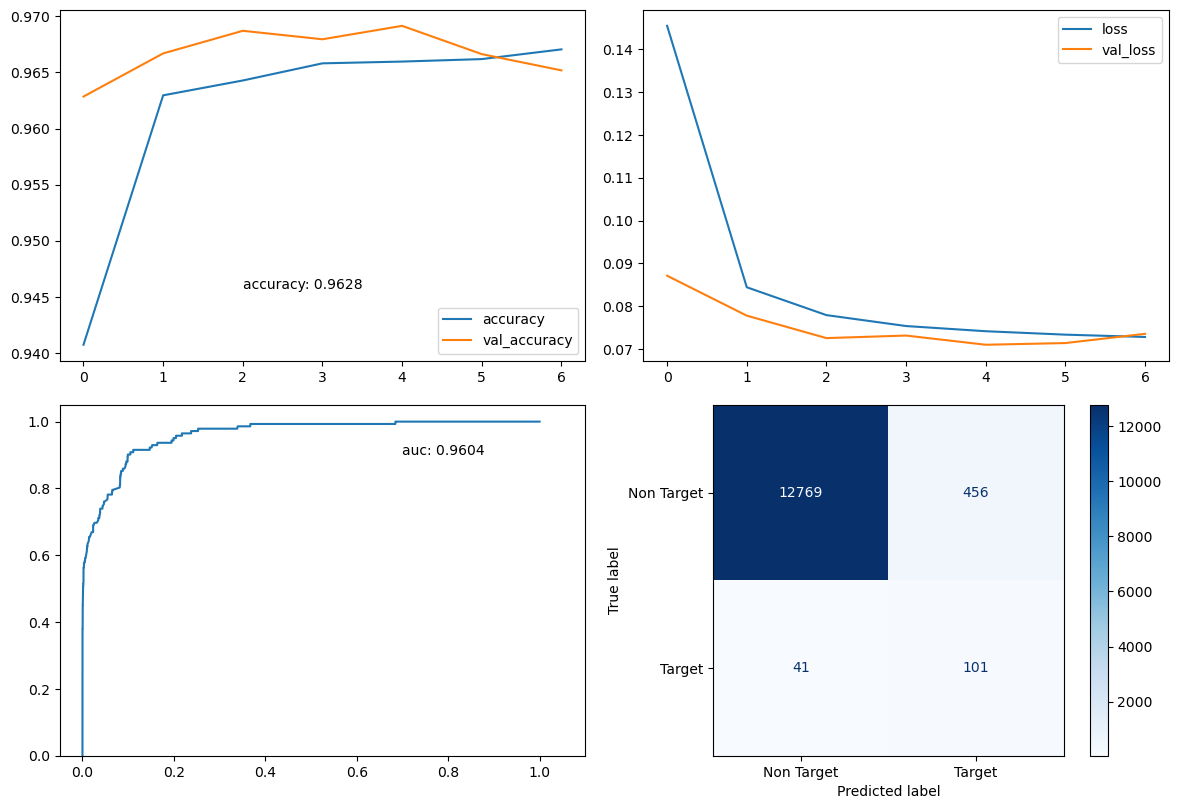

In [12]:
kw = {
    'input_df': input_df,
    'parent_disease': 'MESH:D019636', # neurodegenerative diseases
    'gene_count': 1000,
    'model_type':'DNN',
    'show_plots': True,
    'use_class_weights': False,
    'oversample': True
}
dnn_os = DiseaseClassifier(**kw)
mm = dnn_os.main()

## Iterate over a number of different permutations 

In [ ]:
# import time
# import json
# import datetime
# from itertools import product

# params = {
#     'gene_count': [20, 50, 100, 250, 500, 1000, 2000, 3000, 5000],
#     'parent_disease': ['MESH:D019636'],
#     'model_type': ['CNN', 'DNN'],
#     'use_class_weights': [True, False],
#     'oversample': [True, False]
# }


# permutations = [dict(zip(params, v)) for v in product(*params.values())]

# results = []

# for i, (p) in enumerate(permutations):
#     p['input_df'] = input_df
#     p['show_plots'] = False
#     try:
#         _m = DiseaseClassifier(**p)
#     except Exception:
#         continue
    
#     model_results, _ = _m.main()
#     with open('out_stream.txt', 'a') as f:
#         f.write(json.dumps(model_results) + '\n')
#     results.append(model_results)

# df = pd.DataFrame(results)

# now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
# df.to_csv('final-output/{ts}.csv'.format(ts=now))


## what are the best params to use?

In [14]:
from scipy.interpolate import make_interp_spline, BSpline

results_df = pd.read_csv('final-output/2022-02-28 17:06:09.csv')
display(results_df.sort_values('recall', ascending=False)[:10])

def get_plot(df, metric):
    x_axis = df['gene_count']
    xnew = np.linspace(0, max(x_axis), 300) 
    spl = make_interp_spline(df['gene_count'], df[metric], k=3)
    power_smooth = spl(xnew)

    return xnew, power_smooth

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 9))
dnn_df = results_df[(results_df['model_type'] == 'DNN')]

oversample_df = dnn_df[dnn_df['oversample']]
class_weight_df = dnn_df[dnn_df['use_class_weights']]
no_treatment_df = dnn_df[(dnn_df['oversample'] == False) & (dnn_df['use_class_weights'] == False)]

axes[0].plot(*get_plot(oversample_df, 'auc'), label='Over Sampling - AUC')
axes[0].plot(*get_plot(class_weight_df, 'auc'), label='Class Weight - AUC')
axes[0].plot(*get_plot(no_treatment_df, 'auc'), label='No Treatment - AUC')
axes[0].legend()

axes[1].plot(*get_plot(oversample_df, 'recall'), label='Over Sampling - Recall')
axes[1].plot(*get_plot(class_weight_df, 'recall'), label='Class Weight - Recall')
axes[1].plot(*get_plot(no_treatment_df, 'recall'), label='No Treatment - Recall')
axes[1].legend()


fig.tight_layout()

FileNotFoundError: [Errno 2] No such file or directory: 'final-output/2022-02-28 17:06:09.csv'

## DNN with Multi Class

In [15]:
# do this
kw = {
    'input_df': input_df,
    'parent_disease': 'MESH:D019636', # neurodegenerative diseases
    'gene_count': 1000,
    'model_type':'DNN',
    'show_plots': True,
    'use_class_weights': True,
    'oversample': False,
    'classification': 'categorical'
}
cat = DiseaseClassifier(**kw)
mm, _ = cat.main()

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

### Here we evaluate the chemicals that have posibile therapeutic and harmful effects as it relates to.  We take the chemical to gene network.  I want to see chemicals *not* in the dataset that we can research.

In [ ]:
# instatiate the model to get the relevant genes that we need to process.. dont need to fit the model yet
kw = {
    'input_df': input_df,
    'parent_disease': 'MESH:D019636', # neurodegenerative diseases
    'gene_count': 1000,
    'show_plots': False,
    'oversample': False,
    'use_class_weights': True,
    'classification': 'categorical'
}
chem_cl = DiseaseClassifier(**kw)

inp_df = get_df('CTD_chem_gene_ixns')
inp_df = inp_df[inp_df['GeneSymbol'].isin(chem_cl.top_n_genes)]

## process the chemical -> dataset ( without disease ) in the same way we do our input data
gb_df = inp_df.groupby(['ChemicalName', 'GeneSymbol']).size().reset_index()
gb_df.columns = ['ChemicalName','GeneSymbol', 'InteractionCount']
dummy_df = pd.get_dummies(gb_df, prefix='', prefix_sep='',columns=['GeneSymbol'])

chem_df = dummy_df.groupby(['ChemicalName']).agg({np.max}).reset_index()
chem_df.columns = chem_df.columns.droplevel(1)

predicted_values = chem_cl_model.predict(chem_df[chem_cl.top_n_genes])

predicted_value_df = pd.DataFrame(predicted_values, columns=['Ther', 'Not Relevant', 'Marker'])

final = chem_df.merge(predicted_value_df, left_index=True, right_index=True)
final = final[['ChemicalName', 'Ther', 'Not Relevant', 'Marker']]

print('--- THER ---')
display(final.nlargest(5, 'Ther'))

print('--- MARKER ---')
display(final.nlargest(5, 'Marker'))

# chem_df[:4]

In [ ]:
## ctd says (+)-JQ1 compound	 is associated with the reduction of inflamation
## pub chem says trimethyllead is acutely toxic - https://pubchem.ncbi.nlm.nih.gov/compound/Trimethyllead-acetate is ""

## Understanding feature importance -- what genes are coorelated with Parkinsons / Neurodegenerative diseass

In [ ]:

from sklearn.ensemble import RandomForestClassifier


def feature_importance(features, labels, stop_early=True, show_plots=True):
    input_shape = features.shape[1]
    
    X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=0, train_size=TRAIN_SIZE)

    rand_forest_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rand_forest_classifier.fit(X_train, y_train)

    optimal_node_count = 128
    feature_count = 70
    output_label_len = 10
    imp_arr = rand_forest_classifier.feature_importances_
    
    gene_importance = dict(zip(features.columns, imp_arr))
    gene_importance_df = pd.DataFrame({'gene': features.columns, 'score': imp_arr})

    return gene_importance_df.sort_values('score', ascending=False)

## Gene Importance for Neurodegenrative Diseases

In [ ]:
train_df = chem_cl.prep_training_data()
train_df = chem_cl.set_label(train_df)

gene_columns = train_df.columns.intersection(chem_cl.top_n_genes)

print(len(gene_columns))
shuffled_df = train_df.sample(frac=1)

gene_importance_df = feature_importance(shuffled_df[gene_columns], shuffled_df['binary_label'])

gene_importance_df.hist()

ax = gene_importance_df[:20].plot.bar(y='score', x='gene', rot=0, figsize=(20,10))

## Gene Importance for Parkinsons

In [ ]:
kw = {
    'input_df': input_df,
    'parent_disease': 'MESH:D010300', # parkinsons diseases
    'gene_count': 1000,
    'model_type':'DNN',
    'show_plots': False,
    'oversample': True,
    'use_class_weights': False,
    'classification': 'binary'
}
park_cl = DiseaseClassifier(**kw)
results, park_model = park_cl.main()


train_df = park_cl.prep_training_data()
train_df = park_cl.set_label(train_df)

gene_columns = train_df.columns.intersection(park_cl.top_n_genes)

shuffled_df = train_df.sample(frac=1)

park_gene_importance_df = feature_importance(shuffled_df[gene_columns], shuffled_df['binary_label'])

## https://www.nature.com/articles/ng0892-345 # APP shows up... has strong inference to alzheimers
ax = park_gene_importance_df[:20].plot.bar(y='score', x='gene', rot=0, figsize=(20,10))
